# Reinforcement Learning Lab

<img src="https://miro.medium.com/v2/resize:fit:2000/0*WC4l7u90TsKs_eXj.png" width=500px>


In this notebook, we explore different strategy for Reinforcement Learning for a simple control task, Cart Pole, first introduced by Sutton, Barto and Anderson [1]. We will mainly use PyTorch and Gymnasium, a popular library containing some basic building blocks for training RL agent.

- Gym: https://gymnasium.farama.org/

### Structure
- SARSA
- Q-Learning
- Deep Q-Learning

[1] A. G. Barto, R. S. Sutton and C. W. Anderson, "Neuronlike adaptive elements that can solve difficult learning control problems," in IEEE Transactions on Systems, Man, and Cybernetics, vol. SMC-13, no. 5, pp. 834-846, Sept.-Oct. 1983, doi: 10.1109/TSMC.1983.6313077.


## Cart Pole Environment

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" height="200" />

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

- **Action Space**: push right or push left the cart;
- **Observation Space**: cart position and velocity, pole angle and velocity. All the features are continuous.
- **Reward**: +1 for each timestep we keep the pole upwards (in a certain angle). We have a maximum of 500 timestep.

An **episode** ends when either: make the pole fall, the cart reaches the edges of the line, or we reach 500 timesteps.

You can find the reference implementation [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

In [1]:
import gymnasium as gym

from tqdm import tqdm
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Let us start by first importing the gym library.

In [ ]:
# We create an environment
env = gym.make('CartPole-v1')

We can inspect some basic properties of the selected environment (see documentation above for details).


**Action space**

| Value    | Action  |
| -------- | ------- |
| 0        | Push cart to the left (fixed force)    |
| 1        | Push cart to the right (fixed force)   |


In [ ]:
# Here we show some basic details on an Gym environment
print(env.action_space) # these are the actions the agent can take

Discrete(2)


**Observation space**

| Num    | Observation        | Min     | Max  |
| -------- | ---------------- | ------- | ---- |
| 0        | Cart Position    | -4.8    | 4.8 |
| 1        | Cart Velocity    | -$\inf$ |$\inf$|
| 2        | Pole Angle       | ~-0.418 rad (-24°) | ~0.418 rad (24°) |
| 3        | Pole Angular Velocity    | -$\inf$ |$\inf$|


Note:

- Pole angle of $0°$ $\rightarrow$ pole is perfectly vertical
- Pole angle $> 0°$ $\rightarrow$ pole tilts to the right
- Pole angle $< 0°$ $\rightarrow$ pole pole tilts to the left

In [4]:
# Here we show some basic details of a Gym environment
print(env.observation_space.high) # these are the max values for each observation

[4.8               inf 0.41887903        inf]


To start the game, we need to *reset* the environment.

In [5]:
# We reset the state to a new one.
# State are randomly initialized with values in [-0.05, 0.05].
state, _ = env.reset() # starts a new episode
print(state) # this is the initial state of the environment

[-0.03929101  0.04560397 -0.04105788  0.01930587]


The agent can perform an action in the environment by calling the *step* function, taking as argument the numerical encoding of the action (see table above).


In [6]:
# We perform a certain action and we get some info
new_state, reward, done, truncated, info = env.step(action=0) # we take action 0 -> push cart to the left

print(f"Cart position: {new_state[0]:.3f} \t Pole angle: {new_state[2]:.3f}")
print("Reward:", reward)
print("Info:", info)
print("Game over?", done)

Cart position: -0.038 	 Pole angle: -0.041
Reward: 1.0
Info: {}
Game over? False


In [7]:
# See if the environment responds to our actions as expected (keep going left)
while not done:
  new_state, reward, done, truncated, info = env.step(action=0)
  print(f"Cart position: {new_state[0]:.3f} \t Pole angle: {new_state[2]:.3f}")
  print("Reward:", reward)
  print("Info:", info)
  print("Game over?", done)
  print("-"*20)
print("GAME OVER :(")

Cart position: -0.041 	 Pole angle: -0.035
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.048 	 Pole angle: -0.023
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.059 	 Pole angle: -0.006
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.074 	 Pole angle: 0.017
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.092 	 Pole angle: 0.046
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.115 	 Pole angle: 0.080
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.141 	 Pole angle: 0.121
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.171 	 Pole angle: 0.168
Reward: 1.0
Info: {}
Game over? False
--------------------
Cart position: -0.206 	 Pole angle: 0.222
Reward: 1.0
Info: {}
Game over? True
--------------------
GAME OVER :(


SARSA and Q-Learning estimates an action-value function $Q(s,a)$. During the lecture, we usually assume the environment is discrete in order for $Q(s,a)$ to be learnable. Here, Cart Pole has a **continuous** environment instead, thus we need to perform a **discretization** step.

There are more sofisticated techniques for discretization (such as Tile Coding [2]) but we will not cover them here.

[2] http://www.incompleteideas.net/book/8/node6.html

In [ ]:
#SARSA and Q-Learning need discrete states, so we discretize the environment, i.e., we convert continuous states into discrete ones, like in a grid world.
#The more partitions (bins) we use, the more precise the representation of the state will be, but the larger the Q-table will become.

# Set the random seed
random.seed(2025)
np.random.seed(2025)

# every feature will be discretized into num_bins bins
def discretize(env, num_bins=10): 
  """Discretize each feature into a given number of bins"""
  bins = []
  for feature_low, feature_high in zip(env.observation_space.low, env.observation_space.high):
    bins.append(
        np.linspace(max(-10, feature_low), min(10, feature_high), num=num_bins)
    )
  return bins

def convert_state(state, bins):
  """Given a continuous state, return its binned representation"""
  new_state = []
  for feature, feature_bins in zip(state, bins):
    new_state.append(
        np.digitize(feature, feature_bins)
    )
  return tuple(new_state)

Let us test our new function before actually using it.

In [ ]:
bins = discretize(env) # we create 10 bins for each feature by default
state, _ = env.reset() # starts a new episode
convert_state(state, bins) # converted state into discrete representation using number of bins=10

(np.int64(5), np.int64(5), np.int64(5), np.int64(5))

Let us now define a function which, given $Q(s,a)$ will play an episode of the environment. It will be useful later on.

In [23]:
def play(env, Q, bins):
  """Play an episode using the state-action function Q."""

  state, _ = env.reset()

  done = False
  truncated = False
  total_reward = 0

  while not done and not truncated:

    # env.render() Uncomment this line to see an interactive visualization of the agent
    # in the environment. It works only if this notebook is run as a simple python
    # script on your local environment.

    state = convert_state(state, bins)
    policy_action = np.argmax(Q[state])
    next_state, reward, done, truncated, _ = env.step(action=policy_action)
    state = next_state
    total_reward += reward

  return total_reward

We now define a function to solve the control task by using either SARSA or Q-Learning.

### SARSA (State-Action-Reward-Sate-Action)
<img src="https://tcnguyen.github.io/reinforcement_learning/images/SARSA_algo.png" height="300" />

### Q-Learning
<img src="https://tcnguyen.github.io/reinforcement_learning/images/Q_learning_algo.png" height="300" />





Let us define a function to implement the ϵ-greedy strategy.

In [ ]:
# trade-off between exploration and exploitation

def epsilon_greedy_action(env, Q, state, epsilon):
  if np.random.rand() >= epsilon:
    action = np.argmax(Q[state]) # exploitation
  else:
    action = env.action_space.sample() # exploration
  return action

In [ ]:
# Implement the SARSA on-policy algorithm.

def SARSA(Q, bins, alpha=0.25, gamma=0.9, epsilon=0.3, episodes=100):
  """Implement the SARSA on-policy algorithm."""

  eval_results = []

  for episode in tqdm(range(episodes)):

    state, _ = env.reset()
    state = convert_state(state, bins)

    action = epsilon_greedy_action(env, Q, state, epsilon)

    done = False
    truncated = False

    while not done and not truncated:
      next_state, reward, done, truncated, _ = env.step(action)
      next_state = convert_state(next_state, bins)

      next_action = epsilon_greedy_action(env, Q, next_state, epsilon)

      # SARSA update rule
      Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

      state = next_state
      action = next_action

    # Evaluation step
    if episode % 10 == 0:
      for _ in range(100):
        eval_results.append(
           [episode, play(env, Q, bins)]
        )

  return Q, eval_results

In [ ]:
# Implement the Q-Learning off-policy algorithm.
# differently from SARSA, Q-Learning uses the maximum estimated future reward for the next state, regardless of the action taken.
# it can allow for more exploration since it does not depend on the policy being followed.
# it can find the optimal policy but at the cost of more risk.

def QLearning(Q, bins, alpha=0.25, gamma=0.9, epsilon=0.3, episodes=100):
  """Implement the Q-Learning off-policy algorithm."""
  eval_results = []

  for episode in tqdm(range(episodes)):

    state, _ = env.reset()

    done = False
    truncated = False

    while not done and not truncated:
      state = convert_state(state, bins)
      action = epsilon_greedy_action(env, Q, state, epsilon)

      next_state, reward, done, truncated, _ = env.step(action)
      next_state_converted = convert_state(next_state, bins)

      # Q-Learning update rule
      Q[state][action] += alpha * (reward + gamma * max(Q[next_state_converted]) - Q[state][action])

      state = next_state

    # Evaluation step
    if episode % 10 == 0:
      for _ in range(5):
        eval_results.append(
           [episode, play(env, Q, bins)]
        )

  return Q, eval_results

Let's see how the two agents learn!

In [21]:
# Define the environment
env = gym.make('CartPole-v1')

# Pick the high/low environment values
bins = discretize(env, num_bins=25)

# Initialize value function
Q = np.zeros([25,25,25,25,2]) # Note: this scales quite badly...

In [24]:
Q_sarsa, eval_sarsa = SARSA(np.copy(Q), bins, episodes=5000)
Q_qlearn, eval_qlearning = QLearning(np.copy(Q), bins, episodes=5000)

100%|██████████| 5000/5000 [00:48<00:00, 102.35it/s]


Given the evaluation results, we plot them and compare the two runs:

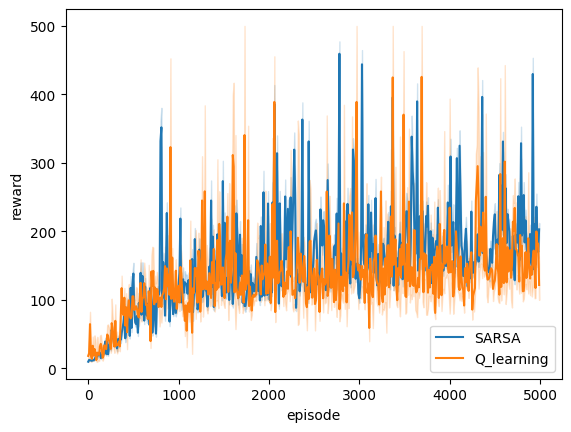

In [25]:
eval_sarsa = pd.DataFrame(eval_sarsa, columns=["episode", "reward"])
eval_qlearning = pd.DataFrame(eval_qlearning, columns=["episode", "reward"])

sns.lineplot(data=eval_sarsa, x="episode", y="reward", label="SARSA")
sns.lineplot(data=eval_qlearning, x="episode", y="reward", label="Q_learning")

plt.show()

No clear difference between SARSA and Q-learning in this (simple) case.
Check out [this example](https://youtu.be/AJiG3ykOxmY?si=QK_A2__jF76aXoCh&t=1308) for a more intuitive understanding of how the different update rule can affect the agent's behaviour.

# Deep Q-Learning

Deep Q-Learning is a technique to learn optimal policies which achieves superhuman performance on many Atari games [3]. It uses a **neural network (NN) as a function approximator** to learn the state-value utility function $Q(s,a)$ without resorting to discretization.

In vanilla **Q-learning**, we optimize the state-value utility $Q(s,a)$ following the Bellman equation:

$$Q(s,a) = R(s) + \gamma \max_{a'} Q(s', a')$$

<!-- In practice, we use a *blended* version to improve on convergence:

$$Q(s,a) = (1-\alpha)Q(s,a) + \alpha \big( R(s) + \gamma \max_a Q(s', a') \big)$$ -->

This means we want to push the value of $Q(s,a)$ to be closer to $R(s) + \gamma \max_{a'} Q(s', a')$, which gets refined as exploration and training progress. This can directly be translated into a **Neural Network loss function**, as follows:

$$ \mathcal L = \big[ Q(s, a) - (R(s) + \gamma \max_{a'} Q(s', a')) \big]^2  $$

**Caveat 1**: Changing the Neural Network's parameters to update the prediction on the tuple $(s,a)$ may affect the $Q$ value for $(s',a')$ as well, making the training unstable (like chasing our own tail). So, in practice, we tipically use two twin Neural Networks:

- **Prediction Network**: Predicts $Q(s,a)$ only.

- **Target Network**: Predicts $Q(s',a')$. Periodically sync the parameters of the target network with the prediction network, to refine the estimates.

<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*nxn5uxtVBUniW1sTzjNbqQ.png'>


In the current notebook, we will implement a simple agent without twin networks, which is left as an exercise.

**Caveat 2**: Training samples of an episode are not i.i.d., which is a key requirement for stable SGD training. So, instead of training on samples coming directly from the environment, a simple strategy is to first store past experiences in a *memory buffer*. We then sample training data from it, in an i.i.d. manner.


Overall, we want to train a neural network to minimize the following loss function:
$$ \mathcal L(\theta) = [ (r + \gamma\cdot\max_{a_{t+1} } Q(s_{t+1}, a_{t+1}; \theta^{target})) - Q(s_t, a_t; \theta^{pred}  )  ]^2  $$



*Mnih, Volodymyr, et al. Playing atari with deep reinforcement learning. 2013.*

*Long-Ji Lin. Reinforcement learning for robots using neural networks. 1993.*

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

We define a replay buffer, which will contain all the agent states and rewards it experiences over training. This aids training effectively the Deep Q-Network.

In [ ]:
# this class can allow us to store and sample experiences

class ReplayBuffer:
    """Replay buffer which will store all the experiences made by the agent in a queue."""
    def __init__(self, capacity):
        self.capacity = capacity
        self.storage = [] # this will store the experiences

    def push(self, state, action, next_state, reward, done): # add a new experience to the buffer

        self.storage.append([
            state, action, next_state, reward, done
        ])

        # When buffer is full, start discarding old experiences
        if len(self.storage) > self.capacity:
            self.storage.pop(0)

    def sample(self, batch_size): # sample a batch of experiences from the buffer
      if len(self) >= batch_size:
        # randomly sample some indexes
        batch = np.random.randint(0, len(self), batch_size).tolist()
      else:
        # if not enough experience, take it all
        batch = list(range(len(self)))

      x, y, u, r, d = [], [], [], [], []
      for i in batch: 
          X, Y, U, R, D = self.storage[i] # get experience at index i
          x.append(np.array(X))
          y.append(np.array(Y))
          u.append(np.array(U))
          r.append(np.array(R))
          d.append(np.array(D))
      return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

    def __len__(self):
        return len(self.storage)

We then define our Q-network.

In [ ]:
# Define Q-network
# it is used to approximate the Q-value function

class QNetwork(nn.Module):
  """Q-Network component we will learn."""

  def __init__(self, input_size, hidden_size, output_size):
    super(QNetwork, self).__init__()
    self.fc = nn.Linear(input_size, hidden_size) #input layer
    self.fc2 = nn.Linear(hidden_size, hidden_size) #hidden layer
    self.fc3 = nn.Linear(hidden_size, output_size) #output layer

  def forward(self, x):
    x = torch.relu(self.fc(x))
    x = torch.relu(self.fc2(x))
    return self.fc3(x)


At last, we can combine all this pieces to build the agent.

In [ ]:
# DQN Agent

class DQNAgent:
    def __init__(self, input_size, hidden_size, output_size, epsilon=0.3, lr=1e-3, gamma=0.9):
      """Initialize all the components of the agent."""

      self.q_network = QNetwork(input_size, hidden_size, output_size)
      self.loss = nn.MSELoss() #loss function
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr) #adam optimizer
      self.gamma = gamma
      self.epsilon = epsilon

    def select_action(self, state, greedy=False):
      """ Implement an epsilon-greedy action selection policy."""
      if np.random.random() <= self.epsilon and greedy:
            return torch.tensor([np.random.randint(0, len(self.q_network(state)))])
      else:
          with torch.no_grad():
            return  torch.tensor([torch.argmax(self.q_network(state))])

    def update_q_network(self, batch):
      """ Perform an optimization step given an experience batch."""

      state_batch, action_batch, next_state_batch, reward_batch, done_batch = batch

      state_batch = torch.FloatTensor(state_batch)
      next_state_batch = torch.FloatTensor(next_state_batch)
      action_batch = torch.LongTensor(action_batch)
      reward_batch = torch.FloatTensor(reward_batch)
      done_batch = torch.FloatTensor(1-done_batch)

      self.optimizer.zero_grad()

      predicted_q_value = self.q_network(state_batch).gather(1, action_batch) # Q(s,a)

      predicted_next_q_value = torch.max(self.q_network(next_state_batch), dim=1)[0].reshape(-1, 1) # max_a Q(s',a')
      expected_q_value = reward_batch + done_batch * self.gamma * predicted_next_q_value

      loss = self.loss(predicted_q_value, expected_q_value)
      loss.backward()
      self.optimizer.step()

Let us write the training script.

In [30]:
def train(agent, env, buffer, num_episodes=500, batch_size=128):
  """Method which train a DQN agent."""

  eval_reward = []

  for episode in tqdm(range(num_episodes)):
    state = torch.tensor(env.reset()[0], dtype=torch.float32)

    while True:
        ##
        # Collect experience
        ##
        action = agent.select_action(state, greedy=True)
        next_state, reward, done, truncate, _ = env.step(action.item())

        buffer.push(
            state, action, torch.tensor(next_state), torch.tensor([reward]), torch.tensor([done])
          ) # store in the buffer the tuple (s,a,s',r,done) -> note that a' is not available, i.e., requires an off-policy method

        # If the simulation has ended, stop here.
        if done or truncate:
          break

        ##
        # If we have enough experience, then we can train
        ##
        if len(buffer) >= batch_size:
          batch = buffer.sample(batch_size)
          agent.update_q_network(batch)

        state = torch.tensor(next_state)

    ##
    # Evaluate agent
    ##
    if (episode+1) % 10 == 0:
      for _ in range(5):
        state = torch.tensor(env.reset()[0], dtype=torch.float32)
        current_reward = 0

        while True:
            action = agent.select_action(state, greedy=False)
            next_state, reward, done, truncate, _ = env.step(action.item())
            state = torch.tensor(next_state, dtype=torch.float32) if not done else None
            current_reward += reward

            if done or truncate:
                break
        eval_reward.append([episode, current_reward])
  return eval_reward

Great! Now it is time to test our creation on the Cart Pole control problem.

In [ ]:
# Initialize environment and agent
env = gym.make('CartPole-v1')
agent = DQNAgent(input_size=env.observation_space.shape[0], hidden_size=64, epsilon=0.3, output_size=env.action_space.n)

# Replay buffer
buffer = ReplayBuffer(capacity=15000)

# Training
num_episodes = 200
batch_size = 64

In [32]:
eval_deepQ = train(agent, env, buffer, num_episodes, batch_size)

100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


Then, we just print again the evaluation results

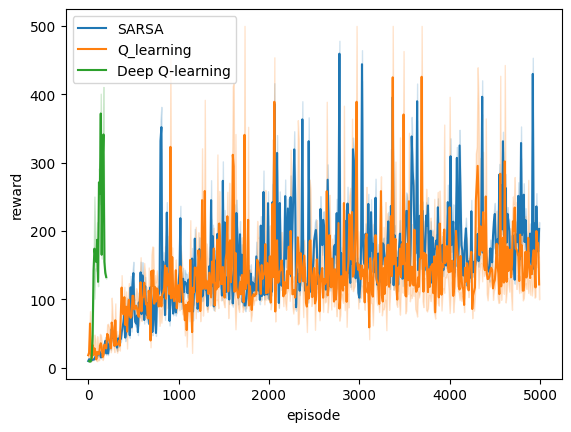

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

eval_deepQ = pd.DataFrame(eval_deepQ, columns=["episode", "reward"])

sns.lineplot(data=eval_sarsa, x="episode", y="reward", label="SARSA")
sns.lineplot(data=eval_qlearning, x="episode", y="reward", label="Q_learning")
sns.lineplot(data=eval_deepQ, x="episode", y="reward", label="Deep Q-learning")

plt.show()

# as we can see, Deep Q-learning outperforms both SARSA and Q-learning in this environment
# it can learn a good policy in fewer episodes

## Additional (*non-mandatory*) Exercises


- Pick a good performing agent among the ones we trained and use *env.render()* to create a .GIF of the played episode
- Pick a new control environment from Gymnasium (e.g., Mountain Car) and try to learn an optimal state-action function.
- Implement the twin Prediction-Target network trick to help stabilize the training (see *Caveat 1* above).
- Read the paper [*Playing Atari with Deep Reinforcement Learning*](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).